## In this notebook we will impute Pressure variable of the WRF data. We have saprately fetched the data from 2019-05-01 to 2019-05-31 in pickel files. 

## The location we will focus is in Florida near Chiefland

## The data will be divided in 70% training and 30% testing, ie Model will be roughly trained on first 20 days and evalute on next 10 days.


In [1]:
# Stating with the relevent Imports

In [11]:
from netCDF4 import Dataset
from netCDF4 import num2date, date2num
import netCDF4
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import autokeras as ak
from math import sqrt
from tensorflow.keras.regularizers import l2, l1
import time
from mpl_toolkits.basemap import Basemap
import argparse
import matplotlib as mpl

### Retreiving data from Pickel file

In [4]:
datafile = open('PickleDataFiles/wrfout_d01_2019_05_01_to_2019_05_31_TPWHNO', 'rb')      
data = pickle.load(datafile) 

### For this notebook we will focus on 'latitude', 'longitude', 'Pressure' variables

In [5]:
data.keys()

dict_keys(['times', 'latitude', 'longitude', 'temperature', 'xWind', 'yWind', 'zWind', 'pressure', 'no2', 'no', 'o3', 'hno3', 'h2o2'])

### Among all the latitude longitude points, these points lies in Florida

In [6]:
#Florida
print(data['latitude'][12][19])
print(data['longitude'][12][19])

28.999317
-82.37851


In [7]:
print('times :' + str(len(data['times'])))
print('Lat :' + str(data['latitude'].shape))
print('Lon :' + str(data['longitude'].shape))
print('Pressure :' + str(data['pressure'].shape))

times :744
Lat :(29, 29)
Lon :(29, 29)
Temperature :(744, 29, 29, 29)


- We can see above that total we have 29*29 Latitude and Longitude Points
- We have 744 data point for a month ie, we have data for each hour (31*24 = 744)
- For Pressure we have 29 level of the data and at each level we have 29*29 gird points at each lat-lon point

### Lets Visualize the Pressure Data, we will plot the bottom most level of the Pressure

In [8]:
minLat=-20
maxLat=80
minLon=-180
maxLon=30

In [9]:
pressure_plot=list(np.concatenate(data['pressure'][0][0]).flat)#zero level
latitude_plot = list(np.concatenate(data['latitude']).flat)
longitude_plot = list(np.concatenate(data['longitude']).flat)

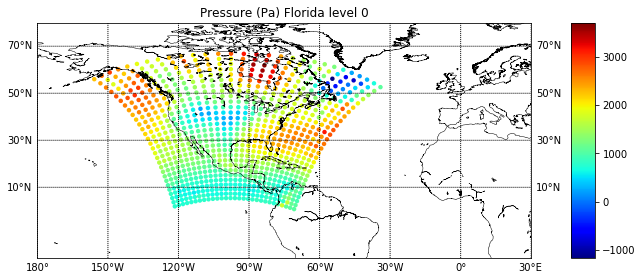

In [13]:
plt.figure(figsize=(10,8))
m = Basemap(projection='cyl', resolution='l',llcrnrlon=minLon, llcrnrlat=minLat, urcrnrlon=maxLon, urcrnrlat=maxLat,lat_0=20.,lon_0=-10.,lat_ts=10.)
#'cyl'
#m = Basemap(projection='cyl', resolution='l',llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49, lat_1=32,lat_2=45,lon_0=-95)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
#GET OCO2 DATA
'''# filter to get oco2 and gosat data seperately
oco2_data = data_set[data_set['dstype'].str.contains("oco2")]
print('Number of OCO2 rows= ' + str(len(oco2_data)))
'''
#    plt.clim(380, 420)
lon_oco2 = np.array(longitude_plot)
lat_oco2 = np.array(latitude_plot)
yrecon_temp = np.array(pressure_plot)


m.scatter(lon_oco2, lat_oco2, c=yrecon_temp, s=20, cmap=plt.cm.jet, edgecolors=None, linewidth=0)
m.colorbar(mappable=None, location='right', size='5%', pad='8%', fig=None, ax=None)
plt.title("Pressure (Pa) Florida level 0")
#plt.savefig('Pressure (Pa) Florida level 0.png')
plt.show()

### Next we will retrieve all the 29 level data point of all the variables at the Florida. Storing them to respective list

In [6]:
lat_loc=12
lon_loc=19
temperature =[]
pressure = []
xWind = []
yWind = []
zWind = []
no2 = []
no = []
o3 = []
hno3 = []
h2o2 = []
for i in range(len(data['temperature'])):
    temperature.append(data['temperature'][i][lat_loc][lon_loc])
    pressure.append(data['pressure'][i][lat_loc][lon_loc])
    xWind.append(data['xWind'][i][lat_loc][lon_loc])
    yWind.append(data['yWind'][i][lat_loc][lon_loc])
    zWind.append(data['zWind'][i][lat_loc][lon_loc])
    no2.append(data['no2'][i][lat_loc][lon_loc])
    no.append(data['no'][i][lat_loc][lon_loc])
    o3.append(data['o3'][i][lat_loc][lon_loc])
    hno3.append(data['hno3'][i][lat_loc][lon_loc])
    h2o2.append(data['h2o2'][i][lat_loc][lon_loc])
    

### As this is time series data so first thing came to mind is to use RNN. A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step. 
### This is Univariate RNN model, so our input and output variable are both Pressure.
### For RNN we need 3D format, and split the data into 3 steps such that first three steps are input and fourth step is the output

In [7]:

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            print("break")
            print(i)
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Emulating Pressure

### This is Univariate RNN model, so our input and output variable are both Pressure.
### For RNN we need 3D format, and split the data into 3 steps such that first three steps are input and fourth step is the output

In [20]:
X_pressure,y_pressure=split_sequence(pressure, 3)

break
741


In [38]:
y_pressure

array([[1172.3984 , 1112.3984 , 1280.8047 , ...,  939.89844, 1125.6875 ,
        1379.5391 ],
       [1162.9609 , 1077.5391 , 1261.2578 , ...,  875.58594, 1098.5    ,
        1346.2656 ],
       [1153.6953 , 1041.1172 , 1240.5234 , ...,  819.71875, 1075.4375 ,
        1312.8516 ],
       ...,
       [1355.7344 , 1290.3125 , 1324.9844 , ...,  562.15625,  664.89844,
         920.47656],
       [1351.2109 , 1296.2578 , 1305.3203 , ...,  582.8828 ,  706.9219 ,
         927.5781 ],
       [1346.1484 , 1302.8594 , 1286.9219 , ...,  596.0469 ,  746.1094 ,
         935.08594]], dtype=float32)

In [21]:
y_pressure.shape

(741, 29)

In [39]:
#standard Deviation of the data
np.std(y_pressure)

342.9899

### Splitting the data with test size of 33 %

In [103]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pressure, y_pressure, test_size=0.33, random_state=42)

### In order to make the model learning easy, lets standardise the input and output data

In [104]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train_p = scaler.fit_transform(X_train_p.reshape(X_train_p.shape[0], -1)).reshape(X_train_p.shape)
X_test_p = scaler.transform(X_test_p.reshape(X_test_p.shape[0], -1)).reshape(X_test_p.shape)

In [114]:
y_train_p = scaler.fit_transform(y_train_p.reshape(y_train_p.shape[0], -1)).reshape(y_train_p.shape)
y_test_p = scaler.fit_transform(y_test_p.reshape(y_test_p.shape[0], -1)).reshape(y_test_p.shape)

### Creating our own loss function as root mean square

In [59]:
def my_objective(y_pred,  y_true):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred-y_true)))

### Constructing Auto Keras model
Steps involved
- Create Input node
- Specify layer with RNN Block, with its own hyperparameter
- Create output node
- Specify AutoModel with hyper parameter mainly on input node, output node and max_trials

In [60]:
input_node_p = ak.Input() 
#out_node = ak.Normalization()(input_node)
#output_node1=ak.ConvBlock()(out_node)
output_node2_p = ak.RNNBlock(return_sequences=True)(input_node_p) 
#output_node = ak.DenseBlock()(output_node) #optional
#output_node = ak.SpatialReduction()(output_node) #optional
#output_node3=ak.DenseBlock(use_batchnorm=True)(output_node2)
output_node_p = ak.RegressionHead(loss=my_objective)(output_node2_p)

auto_model_p = ak.AutoModel(inputs=input_node_p,outputs=output_node_p,overwrite=True,max_trials=100)

### Train the model using fit function, with input data, output data and number epochs

In [61]:
start_time = time.time()
auto_model_p.fit(X_train_p, y_train_p, epochs=100)

Trial 40 Complete [00h 00m 17s]
val_loss: 0.05354798585176468

Best val_loss So Far: 0.02187231183052063
Total elapsed time: 00h 12m 27s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
17/17 [==============================] - 1s 57ms/step - loss: 0.3555 - mean_squared_error: 0.1464 - val_loss: 0.2000 - val_mean_squared_error: 0.0400
Epoch 2/100
17/17 [==============================] - 0s 11ms/step - loss: 0.1808 - mean_squared_error: 0.0329 - val_loss: 0.1524 - val_mean_squared_error: 0.0233
Epoch 3/100
17/17 [==============================] - 0s 11ms/step - loss: 0.1414 - mean_squared_error: 0.0201 - val_loss: 0.1177 - val_mean_squared_error: 0.0139
Epoch 4/100
17/17 [==============================] - 0s 11ms/step - loss: 0.1062 - mean_squared_error: 0.0113 - val_loss: 0.0864 - val_mean_squared_error: 0.0075
Epoch 5/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0815 - mean_squared_error: 0.0067 - val_loss: 0.0690 - val_mean_squared_error: 0.0048
Epoch 6/100
17/

Epoch 97/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0198 - mean_squared_error: 3.9217e-04 - val_loss: 0.0200 - val_mean_squared_error: 4.0471e-04
Epoch 98/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0202 - mean_squared_error: 4.0826e-04 - val_loss: 0.0191 - val_mean_squared_error: 3.7045e-04
Epoch 99/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0195 - mean_squared_error: 3.8338e-04 - val_loss: 0.0193 - val_mean_squared_error: 3.7864e-04
Epoch 100/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0191 - mean_squared_error: 3.6702e-04 - val_loss: 0.0199 - val_mean_squared_error: 4.0104e-04


### Time taken to Run the model

In [62]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 773.9807651042938 seconds ---


### Making prediction on our testing input data and noting the prediction time

In [109]:
start_time_predict = time.time()
predicted_p=auto_model_p.predict(X_test_p)
print("--- %s seconds ---" % (time.time() - start_time_predict))

--- 1.5867581367492676 seconds ---


In [112]:
#Predicted Pressure
predicted_p

array([[0.6305666 , 0.6020947 , 0.5925266 , ..., 0.24423939, 0.4545079 ,
        0.41942203],
       [0.83944553, 0.8259759 , 0.801029  , ..., 0.59157515, 0.6891493 ,
        0.5948842 ],
       [0.35377428, 0.39305317, 0.4324726 , ..., 0.34452465, 0.67507565,
        0.5564115 ],
       ...,
       [0.32465   , 0.20880705, 0.31479308, ..., 0.23766765, 0.4776602 ,
        0.49246657],
       [0.5466373 , 0.34565637, 0.27439997, ..., 0.89013875, 0.8101711 ,
        0.7670056 ],
       [0.62160087, 0.60241807, 0.6297472 , ..., 0.54243076, 0.6747477 ,
        0.6043163 ]], dtype=float32)

### In order to make the comparison of testing and predicted data we need to denormalize it to its orgnal form

In [118]:
#This code will denormalize our predicted data, so we can compare it to our orignal data
def denormalized(origin_data, output_data):
    max_value=origin_data.max()
    min_value=origin_data.min()
    return output_data*(max_value-min_value)+min_value

In [95]:
predicted_p.shape

(245, 29)

In [119]:

predicted_p=denormalized(y_pressure, predicted_p)
y_test_p=denormalized(y_pressure, y_test_p)

In [120]:
predicted_de.shape

(245, 29)

### R-squared is a relative measure of fit, R-squared is around 98% reveals that 98% of the data fits the regression model.
### RMSE is an absolute measure of fit. RMSE is measure of the average deviation of the estimates from the observed values or is the square root of the variance of the residuals.

In [121]:
r2_p = r2_score(predicted_p,y_test_p)
rmse_p = sqrt(mean_squared_error(predicted_p,y_test_p))

In [122]:
print(r2_p)
print(rmse_p)

0.9873132922958914
57.33983510137717


### Export the model to save the config

In [123]:
auto_model_t=auto_model_p.export_model()

### Saving the Model Architecture Configurations

In [131]:

f = open("images_data/Pressure_Model_config_Florida.txt", "w")
f.write(str(auto_model_t.get_config()))
f.close()

### Lets Visualize the Test vs Predicted data

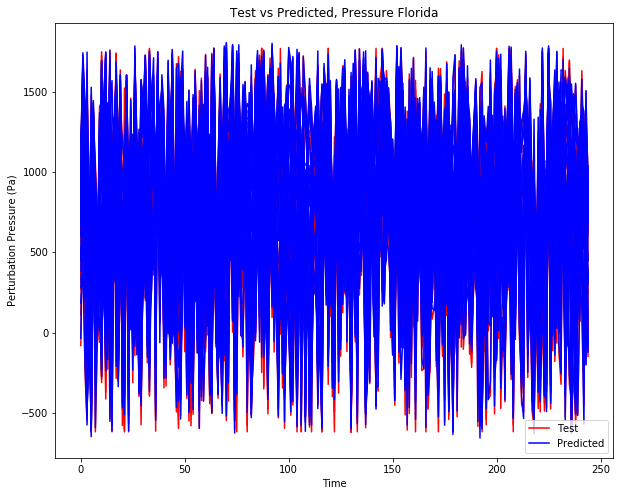

In [127]:
plt.figure(figsize=(10,8))
plt.title('Test vs Predicted, Pressure Florida')
plt.xlabel('Time')
plt.ylabel('Perturbation Pressure (Pa)')
plt.plot(y_test_p, 'r',label='Test')
plt.plot(predicted_p, 'b',label='Predicted')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
#plt.legend()
plt.savefig('images_data/Pressure for Florida.png')
plt.show()

### The plot looks convencing as almost all test data points are covered by predicted data. 

### Saving the model and its weight so that we can use it later to make more predictions

In [132]:
try:
    auto_model_t.save("Model_save/model_autokeras_pressure_florida", save_format="tf")
except Exception:
    auto_model_t.save("Model_save/model_autokeras_pressure_florida.h5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Model_save/model_autokeras_pressure_florida/assets


### To get a closer look lets plot the single time and location

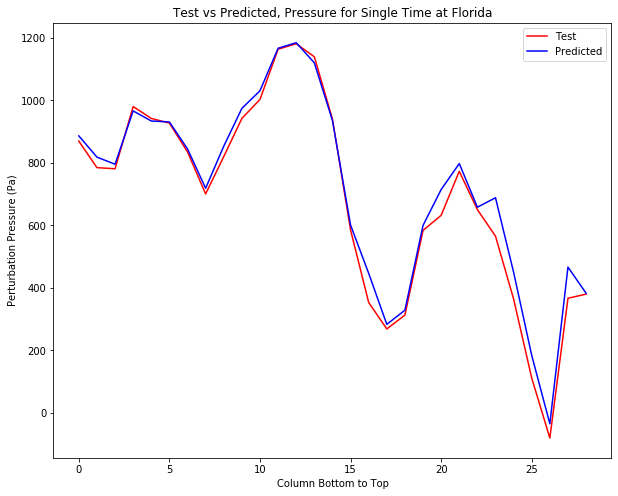

In [130]:
plt.figure(figsize=(10,8))
plt.title('Test vs Predicted, Pressure for Single Time at Florida')
plt.xlabel('Column Bottom to Top')
plt.ylabel('Perturbation Pressure (Pa)')
plt.plot(y_test_p[0], 'r', label='Test')
plt.plot(predicted_p[0], 'b', Label = 'Predicted')
plt.legend()
plt.savefig('images_data/Pressure for Single Time at Florida_0.png')
plt.show()